In [1]:
from pypendula import PyPendula
import numpy as np

#### $n=1$

In [2]:
pendula1 = PyPendula(N=1)
pendula1.solve_symbolic()
pendula1.eom

Matrix([[l*m*(g*sin(q0(t)) + l*Derivative(p0(t), t))]])

In [3]:
pendula1.symbolic_dp

Matrix([[-g*sin(q0(t))/l]])

In [4]:
pendula1.solve_numeric()
# pendula1.lagranges_method._q
# pendula1.lagranges_method._qdots
# pendula1.lagranges_method._qdoubledots
pendula1.soln_hamiltonian

array([-3.08018683, -3.08018665, -3.0801847 , -3.08018257, -3.08018233,
       -3.08018452, -3.08018759, -3.08018757, -3.08016912, -3.08013784,
       -3.08010806, -3.08009136, -3.08009359, -3.08011372, -3.08014453,
       -3.08017508, -3.08019478, -3.08019766, -3.08017077, -3.08012069,
       -3.08006582, -3.08002424, -3.08000921, -3.08002634, -3.08007233,
       -3.08013561, -3.08019899, -3.08024413, -3.08025778, -3.08023966,
       -3.08020311, -3.08016403, -3.08013586, -3.08012697, -3.0801394 ,
       -3.08016896, -3.0802066 , -3.08024078, -3.08026087, -3.08025967,
       -3.08023146, -3.08018858, -3.08014743, -3.0801218 , -3.08011955,
       -3.08014105, -3.08017935, -3.0802223 , -3.08025642, -3.08027219,
       -3.08026451, -3.08022575, -3.0801715 , -3.08012048, -3.08008851,
       -3.08008513, -3.0801118 , -3.08016174, -3.08022141, -3.08027373,
       -3.080303  , -3.08030147, -3.08027607, -3.08024071, -3.08020987,
       -3.08019459, -3.08020005, -3.0802247 , -3.08026104, -3.08

#### $n=2$

In [5]:
pendula2 = PyPendula(N=2)
pendula2.solve_symbolic()
pendula2.eom

Matrix([
[l*m*(2*g*sin(q0(t)) + l*p1(t)**2*sin(q0(t) - q1(t)) + l*cos(q0(t) - q1(t))*Derivative(p1(t), t) + 2*l*Derivative(p0(t), t))],
[    l*m*(g*sin(q1(t)) - l*p0(t)**2*sin(q0(t) - q1(t)) + l*cos(q0(t) - q1(t))*Derivative(p0(t), t) + l*Derivative(p1(t), t))]])

In [6]:
pendula2.symbolic_dp

Matrix([
[     2*g*sin(q0(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - g*sin(q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + l*p0(t)**2*sin(q0(t) - q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + l*p1(t)**2*sin(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l)],
[-2*g*sin(q0(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + 2*g*sin(q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - 2*l*p0(t)**2*sin(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - l*p1(t)**2*sin(q0(t) - q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l)]])

#### $n=3$

In [7]:
pendula3 = PyPendula(N=3)
pendula3.solve_symbolic()
pendula3.eom

Matrix([
[l*m*(3*g*sin(q0(t)) + 2*l*p1(t)**2*sin(q0(t) - q1(t)) + l*p2(t)**2*sin(q0(t) - q2(t)) + 2*l*cos(q0(t) - q1(t))*Derivative(p1(t), t) + l*cos(q0(t) - q2(t))*Derivative(p2(t), t) + 3*l*Derivative(p0(t), t))],
[l*m*(2*g*sin(q1(t)) - 2*l*p0(t)**2*sin(q0(t) - q1(t)) + l*p2(t)**2*sin(q1(t) - q2(t)) + 2*l*cos(q0(t) - q1(t))*Derivative(p0(t), t) + l*cos(q1(t) - q2(t))*Derivative(p2(t), t) + 2*l*Derivative(p1(t), t))],
[        l*m*(g*sin(q2(t)) - l*p0(t)**2*sin(q0(t) - q2(t)) - l*p1(t)**2*sin(q1(t) - q2(t)) + l*cos(q0(t) - q2(t))*Derivative(p0(t), t) + l*cos(q1(t) - q2(t))*Derivative(p1(t), t) + l*Derivative(p2(t), t))]])

In [8]:
pendula3.symbolic_dp

Matrix([
[   -3*g*sin(q0(t))*cos(q1(t) - q2(t))**2/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 6*g*sin(q0(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) - 4*g*sin(q1(t))*cos(q0(t) - q1(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 2*g*sin(q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 2*g*sin(q2(t))*cos(q0(t) - q1(t))*cos(q1(t) - q2(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) - 2*g*sin(q2(t))*cos(

Saving animation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


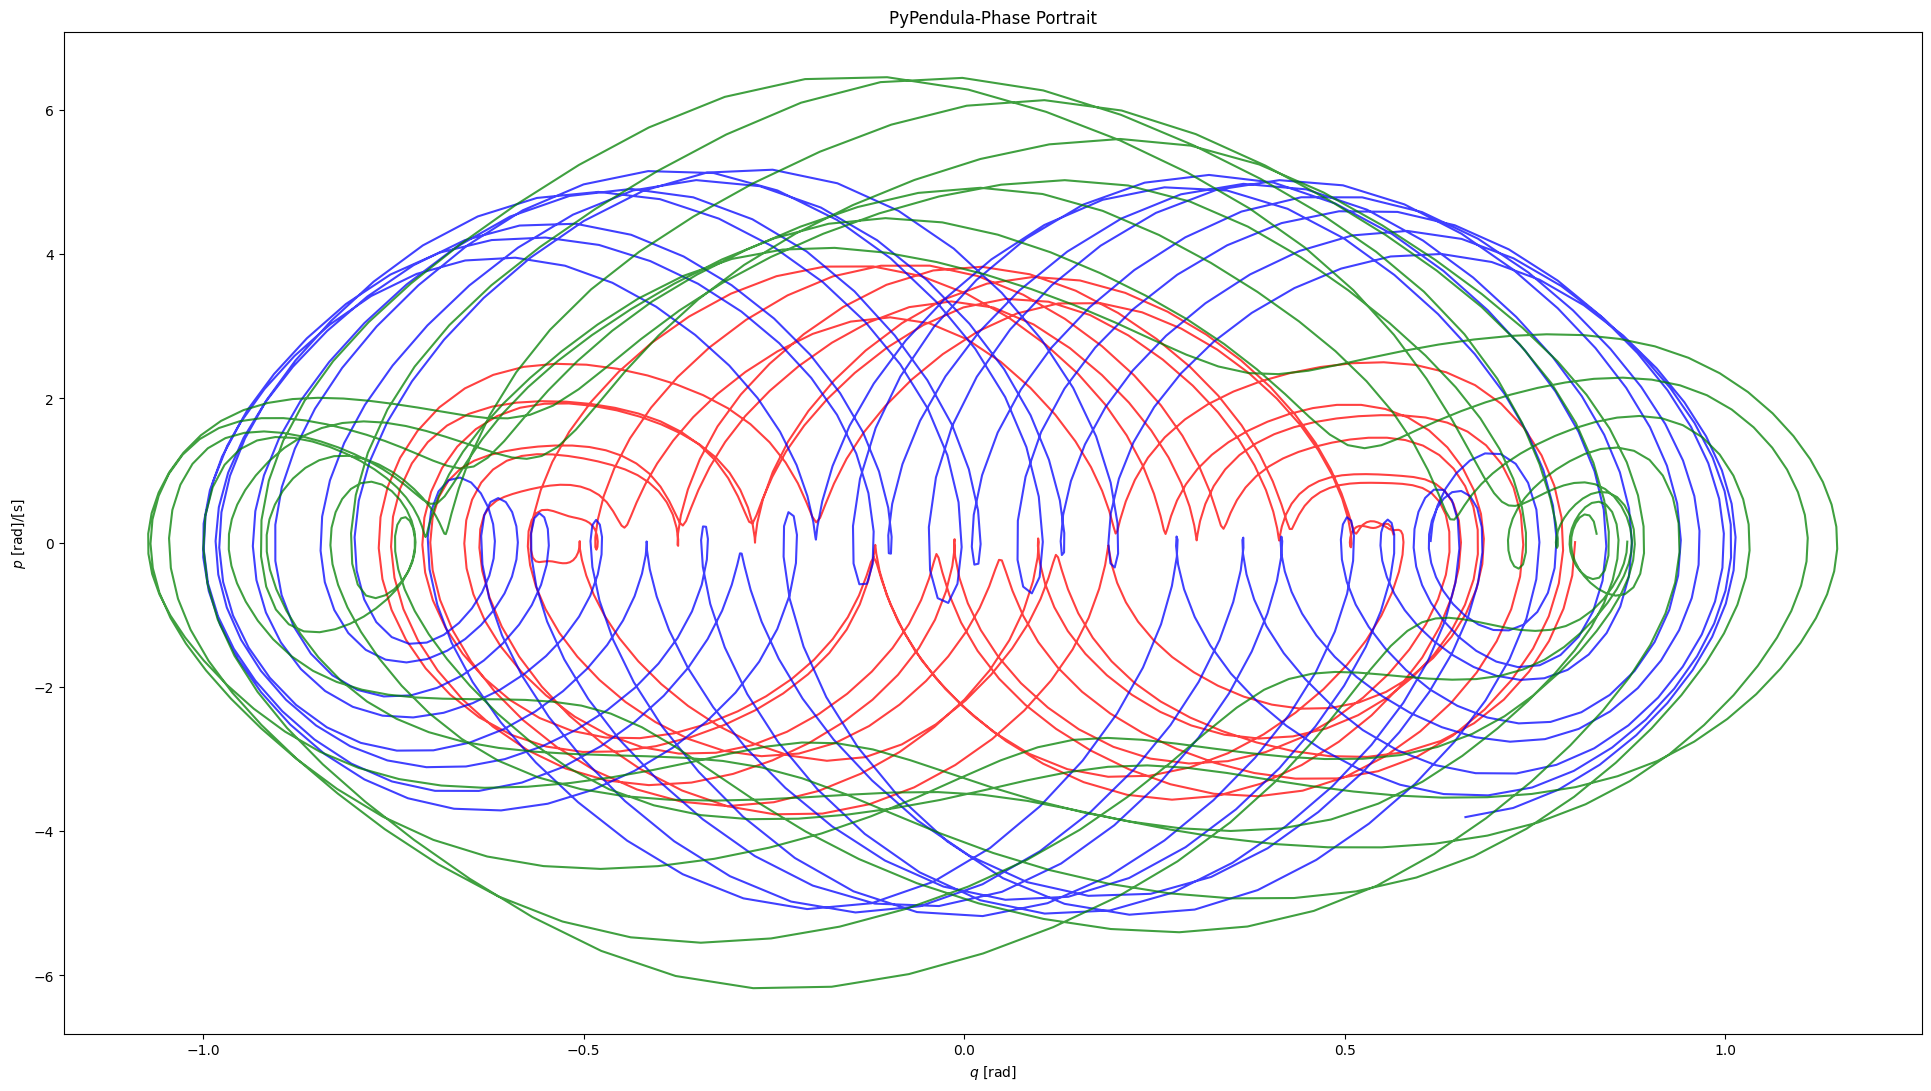

In [9]:
pendula = PyPendula(t_f=15, fps=60, alpha=3, beta=128)

pendula.show_phase_portrait()
pendula.simulate()

In [10]:
for _ in range(3):
    pendula.set_ics()
    pendula.solve_numeric()
    pendula.show_phase_portrait()
    pendula.simulate()

In [ ]:
# def gen_rand_ics(q_param=RAND_PARAMS['q_param'], p_param=RAND_PARAMS['p_param']):
#     return np.stack([
#         q_param * rng.uniform(low=-np.pi, high=np.pi, size=3),
#         p_param * rng.random(size=3)]).flatten()